In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets
import matplotlib.patches as mpatches
from torch.utils.data import DataLoader
from scikit_posthocs import posthoc_dunn
from scipy.stats import mannwhitneyu, kruskal

# Load Data

### CIFAR-10H

Remove annotators that: 
1) failed more than 2 attention check questions
2) had an average annotation time that was an outlier
3) logged a negative reaction time.

In [2]:
cifar_df = pd.read_csv('cifar10h-raw.csv')

cifar_df = cifar_df.rename(columns={'cifar10_test_test_idx': 'cifar10_test_set_idx'})

# Number of rows
num_rows = len(cifar_df)

# Number of unique annotator IDs
num_annotators = cifar_df['annotator_id'].nunique()

print("Number of rows:", num_rows)
print("Number of annotators:", num_annotators)

Number of rows: 539910
Number of annotators: 2571


In [3]:
# Calculate the number of failed attention check questions for each annotator
failed_attention_check_count = cifar_df[(cifar_df['is_attn_check'] == 1) & 
                                        (cifar_df['correct_guess'] == 0)].groupby('annotator_id').size()


# Remove annotators who failed more than 2 attention check questions
dropped_annotators = failed_attention_check_count[failed_attention_check_count > 2].index
cifar_df = cifar_df[cifar_df['annotator_id'].apply(lambda x: x not in dropped_annotators)]

# Remove attention check samples
cifar_df = cifar_df[cifar_df['is_attn_check'] != 1]

# Remove negative reaction times
cifar_df = cifar_df[cifar_df['reaction_time'] >= 0]

# Remove annotators with outlier average reaction times
average_rt_per_annotator = cifar_df.groupby('annotator_id')['reaction_time'].mean()
mean_rt = average_rt_per_annotator.mean()
std_dev_rt = average_rt_per_annotator.std()
threshold = 3 * std_dev_rt
outlier_annotators = average_rt_per_annotator[(average_rt_per_annotator < mean_rt - threshold) | 
                                              (average_rt_per_annotator > mean_rt + threshold)].index
cifar_df = cifar_df[cifar_df['annotator_id'].apply(lambda x: x not in outlier_annotators)]

# Filter reaction_time <= 2500
nofilter_cifar_df = cifar_df.copy()
cifar_df = cifar_df[cifar_df['reaction_time'] <= 2500]

### SDOGS

Within our 2500ms cohort, we reviewed images with a majority of incorrect answers and found 5 images incorrectly labeled in the Stanford Dogs dataset.

In [4]:
prolific_df = pd.read_csv('prolific-data.csv')
# Remove our identified mislabeled image samples
noisy_label_ids = [174, 37, 204, 105, 7]
prolific_df = prolific_df[~prolific_df['test_qid'].isin(noisy_label_ids)]
prolific_df.columns

Index(['participant_id', 'viewtime', 'test_qid', 'timetaken', 'answer',
       'stanford_label', 'stanford_label_idx', 'stanford_sampleid',
       'image_filename'],
      dtype='object')

In [5]:
qualtrics_df = pd.read_csv('qualtrics-data.csv')
qualtrics_df.columns

Index(['participant_id', 'duration', 'pet_dog', 'difficulty', 'features',
       'feedback', 'prolific_time', 'PosAffect', 'NegAffect', 'ATTC_FOC',
       'ATTC_SHIF'],
      dtype='object')

In [6]:
sdogs_df = pd.merge(prolific_df, qualtrics_df, on='participant_id', how='inner')

columns_to_keep = ['participant_id', 'viewtime',
                   'test_qid', 'timetaken', 'answer', 'stanford_label', 
                   'stanford_label_idx',  'stanford_sampleid', 'image_filename', 
                   'pet_dog', 'difficulty', 'features', 'feedback', 'prolific_time',
                   'ATTC_FOC', 'ATTC_SHIF', 'PosAffect', 'NegAffect']

sdogs_df = sdogs_df[columns_to_keep].copy()

sdogs_df['correct'] = sdogs_df['answer'] == sdogs_df['stanford_label']

In [7]:
def easy_correctness(row):
    if row['stanford_label'] == 'cairn':
        return row['answer'] in ['cairn', 'Yorkshire_terrier']
    elif row['stanford_label'] == 'Yorkshire_terrier':
        return row['answer'] in ['cairn', 'Yorkshire_terrier']
    else:
        return row['correct']

sdogs_df['easy_correct'] = sdogs_df.apply(easy_correctness, axis=1)

In [8]:
sdogs_df.columns

Index(['participant_id', 'viewtime', 'test_qid', 'timetaken', 'answer',
       'stanford_label', 'stanford_label_idx', 'stanford_sampleid',
       'image_filename', 'pet_dog', 'difficulty', 'features', 'feedback',
       'prolific_time', 'ATTC_FOC', 'ATTC_SHIF', 'PosAffect', 'NegAffect',
       'correct', 'easy_correct'],
      dtype='object')

# RQ1: How does time limit impact individual participant accuracy?

In [9]:
# Calculate accuracy for CIFAR
cifar_accuracy = cifar_df.groupby('annotator_id')['correct_guess'].mean()

# Group by 'participant_id' and calculate mean corrected accuracy
sdogs_corrected_accuracy = sdogs_df.groupby('participant_id')['easy_correct'].mean()

In [10]:
from scipy.stats import mannwhitneyu

viewtimes = [100, 1000, 2500]
sdogs_corrected_accuracy_by_viewtime = {viewtime: sdogs_df[sdogs_df['viewtime'] == viewtime].groupby('participant_id')['easy_correct'].mean()
                                   for viewtime in viewtimes}

# Number of comparisons for Bonferroni correction
num_comparisons = len(viewtimes)

# Perform the Mann-Whitney U test
for viewtime in viewtimes:
    sdogs_corrected_accuracy = sdogs_corrected_accuracy_by_viewtime[viewtime]
    print(f"SDOGS Corrected Accuracy for viewtime {viewtime}: {sdogs_corrected_accuracy.mean():.4f}")

    # Conduct Mann-Whitney U test between CIFAR and SDOGS corrected accuracies for this viewtime
    u_stat, p_value = mannwhitneyu(cifar_accuracy, sdogs_corrected_accuracy, alternative='two-sided')
    
    # Apply Bonferroni correction
    corrected_p_value = min(p_value * num_comparisons, 1.0)
    
    print(f"Mann-Whitney U test (CIFAR vs SDOGS Corrected, viewtime {viewtime}): U={u_stat}, original p={p_value}, corrected p={corrected_p_value}")

SDOGS Corrected Accuracy for viewtime 100: 0.8832
Mann-Whitney U test (CIFAR vs SDOGS Corrected, viewtime 100): U=22740.0, original p=1.6654100884434175e-05, corrected p=4.9962302653302526e-05
SDOGS Corrected Accuracy for viewtime 1000: 0.9783
Mann-Whitney U test (CIFAR vs SDOGS Corrected, viewtime 1000): U=10426.0, original p=0.32434541810937856, corrected p=0.9730362543281357
SDOGS Corrected Accuracy for viewtime 2500: 0.9598
Mann-Whitney U test (CIFAR vs SDOGS Corrected, viewtime 2500): U=18798.5, original p=0.00900551505067639, corrected p=0.02701654515202917


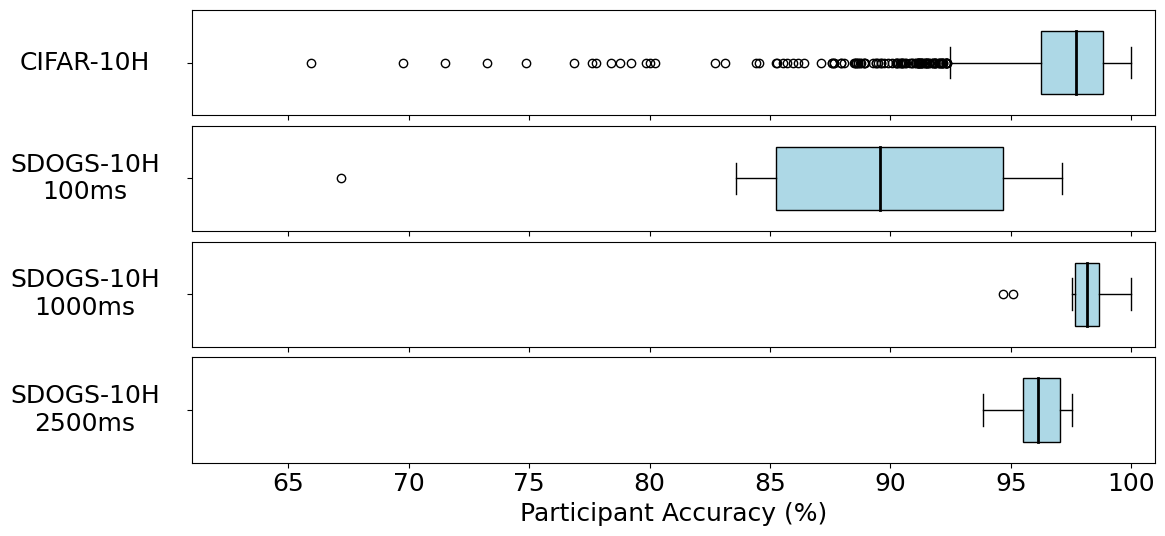

In [11]:
# Convert accuracies to percentages
cifar_accuracy_percent = [x * 100 for x in cifar_accuracy]
sdogs_corrected_accuracy_by_viewtime_percent = {viewtime: [x * 100 for x in acc] for viewtime, acc in sdogs_corrected_accuracy_by_viewtime.items()}

# Ensure accuracy lists for each viewtime are gathered separately
viewtime_accuracies = {viewtime: sdogs_corrected_accuracy_by_viewtime_percent[viewtime] for viewtime in viewtimes}

# Convert CIFAR accuracy to list
cifar_accuracy_list = cifar_accuracy_percent

# Determine the x-axis limits
all_accuracies = cifar_accuracy_list + [acc for viewtime in viewtimes for acc in viewtime_accuracies[viewtime]]
x_limits = (61, 101)

# Plot settings
plt.rcParams.update({'font.size': 18})

# Create a combined plot with CIFAR-10H and SDOGS-10H subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)

# CIFAR-10H plot
boxplot_cifar = axes[0].boxplot(cifar_accuracy_list, vert=False, patch_artist=True, medianprops=dict(color='black', linewidth=2), widths=0.6)
for patch in boxplot_cifar['boxes']:
    patch.set_facecolor('#ADD8E6')  # Set the same color as the rest
axes[0].set_xlim(x_limits)
axes[0].set_ylabel('CIFAR-10H', labelpad=70, rotation=0, ha='center', va='center')
axes[0].set_yticklabels([])  # Remove y-axis labels

# SDOGS-10H subplots for each viewtime
for i, viewtime in enumerate(viewtimes):
    data_to_plot = viewtime_accuracies[viewtime]
    labels = [f'{viewtime}ms Corrected']
    colors = ['#ADD8E6']  # Lighter blue for corrected accuracy
    
    boxplots = axes[i+1].boxplot([data_to_plot], vert=False, patch_artist=True, medianprops=dict(color='black', linewidth=2), widths=0.6)
    axes[i+1].set_yticklabels([])  # Remove y-axis labels
    axes[i+1].set_xlim(x_limits)
    axes[i+1].set_ylabel(f'SDOGS-10H\n{viewtime}ms', labelpad=70, rotation=0, ha='center', va='center')
    
    # Color the boxplots
    for patch, color in zip(boxplots['boxes'], colors):
        patch.set_facecolor(color)

# Set the x-axis label for the bottom plot
axes[-1].set_xlabel('Participant Accuracy (%)')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make room for the legend
plt.subplots_adjust(hspace=0.1)  # Reduce space between plots

# Save the combined plot
plt.savefig('boxplot-cifar10h-sdogs10h.pdf', dpi=300, bbox_inches='tight')
plt.show()

# RQ2. What is the trade-off between overall performance accuracy and varying time limits?

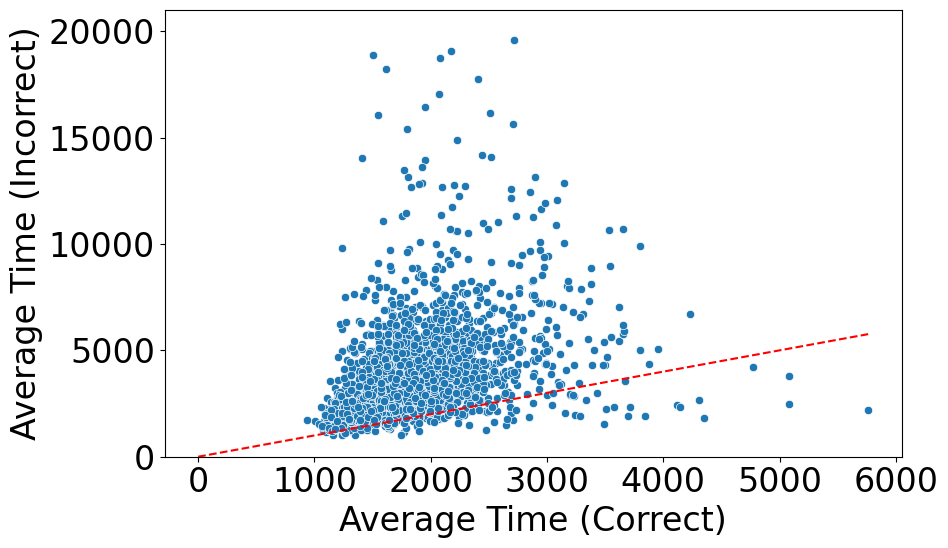

Overall Mean Reaction Time for Incorrect Answers: 3755.0947701464893
Overall Mean Reaction Time for Correct Answers: 1828.57578105598
Correlation between Mean Reaction Time (Correct Answers) and Mean Reaction Time (Incorrect Answers): 0.3599160645903019


In [12]:
# Calculate mean reaction time for each annotator and their correctness
cifar_mean_reaction_time = nofilter_cifar_df.groupby(['annotator_id', 'correct_guess'])['reaction_time'].mean().reset_index()

# Filter for rows where correct_guess is 0 (incorrect)
cifar_incorrect_answers = cifar_mean_reaction_time[cifar_mean_reaction_time['correct_guess'] == 0].rename(columns={'reaction_time': 'reaction_time_wrong'})

# Filter for rows where correct_guess is 1 (correct)
cifar_correct_answers = cifar_mean_reaction_time[cifar_mean_reaction_time['correct_guess'] == 1].rename(columns={'reaction_time': 'reaction_time_correct'})

# Merge the two mean reaction time dataframes on annotator_id
cifar_correct_incorrect_df = pd.merge(cifar_incorrect_answers, cifar_correct_answers, on='annotator_id', how='inner')

# Plot the results
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(10, 6))
sns.scatterplot(x='reaction_time_correct', y='reaction_time_wrong', data=cifar_correct_incorrect_df)
plt.plot([0, cifar_correct_incorrect_df['reaction_time_correct'].max()], 
         [0, cifar_correct_incorrect_df['reaction_time_correct'].max()], 
         linestyle='--', color='red')
plt.ylim(0, 21000)
plt.xlabel('Average Time (Correct)')
plt.ylabel('Average Time (Incorrect)')
plt.tight_layout()
plt.savefig('correct-vs-incorrect.pdf', dpi=300)
plt.show()

# Calculate correlation
correlation = np.corrcoef(cifar_correct_incorrect_df['reaction_time_correct'], cifar_correct_incorrect_df['reaction_time_wrong'])[0, 1]

print("Overall Mean Reaction Time for Incorrect Answers:", cifar_incorrect_answers['reaction_time_wrong'].mean())
print("Overall Mean Reaction Time for Correct Answers:", cifar_correct_answers['reaction_time_correct'].mean())
print("Correlation between Mean Reaction Time (Correct Answers) and Mean Reaction Time (Incorrect Answers):", correlation)

In [13]:
### Count the number of annotators below and above the diagonal line
below_diagonal = cifar_correct_incorrect_df[cifar_correct_incorrect_df['reaction_time_wrong'] < 
                                            cifar_correct_incorrect_df['reaction_time_correct']].shape[0]
above_diagonal = cifar_correct_incorrect_df[cifar_correct_incorrect_df['reaction_time_wrong'] > 
                                            cifar_correct_incorrect_df['reaction_time_correct']].shape[0]

print("Number of annotators below the diagonal line:", below_diagonal)
print("Number of annotators above the diagonal line:", above_diagonal)

Number of annotators below the diagonal line: 118
Number of annotators above the diagonal line: 2425


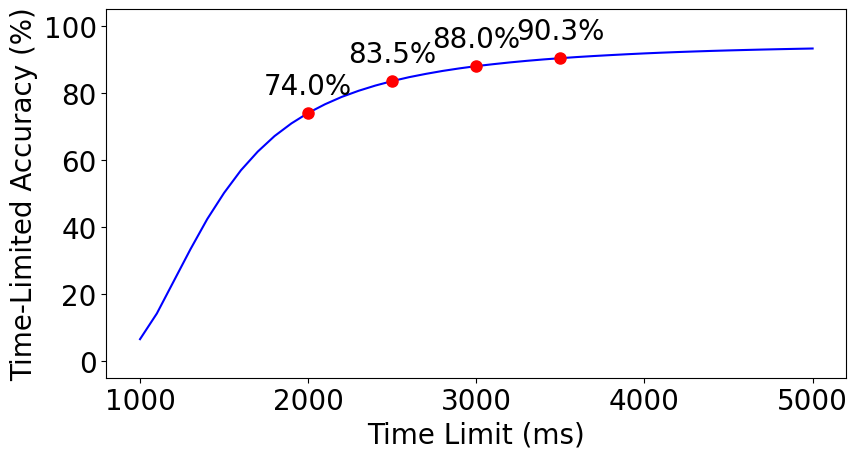

In [14]:
# Define the range of time limits (in milliseconds)
time_limits = np.arange(1000, 5100, 100)

# Initialize a list to store overall accuracies
cifar_overall_accuracies = []

for limit in time_limits:
    # Create a copy of the original data to avoid modifying the original dataframe
    nofilter_cifar_df_copy = nofilter_cifar_df.copy()
    
    # Update correctness value for reaction times beyond the limit
    nofilter_cifar_df_copy.loc[nofilter_cifar_df_copy['reaction_time'] > limit, 'correct_guess'] = 0
    
    # Calculate overall accuracy
    cifar_overall_accuracy = nofilter_cifar_df_copy['correct_guess'].mean() * 100  # Convert to percentage
    
    # Append overall accuracy to the list
    cifar_overall_accuracies.append(cifar_overall_accuracy)

# Plot
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(9, 5))

# Plot overall accuracy
plt.plot(time_limits, cifar_overall_accuracies, color='blue', label='Overall Accuracy', linestyle='-')
plt.xlabel('Time Limit (ms)')
plt.ylabel('Time-Limited Accuracy (%)')  # Update y-axis label to indicate percentage
plt.ylim(-5, 105)  # Set y-axis limit to 100
# plt.title('Overall Accuracy for Different Time Limits')
# plt.grid(True)

# Add points and annotate the accuracy at specific time limits
for limit, accuracy in zip(time_limits, cifar_overall_accuracies):
    if limit in [2000, 2500, 3000, 3500]:
        plt.plot(limit, accuracy, marker='o', markersize=8, color='red')  # Add point
        plt.text(limit, accuracy + 4, f'{accuracy:.1f}%', ha='center', va='bottom')  # Annotate accuracy with percentage, offset text upwards

# Show plot
# plt.legend()
plt.tight_layout()
plt.savefig('time-limited-accuracy.pdf', dpi=300)
plt.show()

# RQ3: Which images are more difficult under a view time limit?

In [15]:
# Manually annotated image ids categorised by image types that participants reflected wanting more time on in our survey
diff_ft_ids = {}
diff_ft_ids['non-dog'] = [603, 696, 17379, 615, 613, 19677, 6584, 17180, 10023, 10018, 16512, 19754, 6523, 10033, 10091, 7576, 14434, 10117, 16575, 14464, 10060, 10142, 16552, 14365, 730, 14441, 708, 14456, 6547]
diff_ft_ids['multi-dog'] = [17180, 7527, 16573, 16602, 10099, 16623, 10077, 17279, 16516, 16572]
diff_ft_ids['puppy'] = [5192, 14447, 19760, 6579, 17253, 714, 6541, 650, 19684, 16646, 14018, 14342, 680, 6665, 719, 6658, 10080, 713, 7491, 14019, 16508, 13887, 6597, 13966, 595]
diff_ft_ids['small'] = [603, 17253, 16602, 19677, 10023, 10018, 16601, 19700, 17275, 14022, 19666, 19691, 731, 17320, 14359, 17288]
diff_ft_ids['low-light'] = [19677, 16573, 6584, 6579, 17180, 13954, 5205, 19712, 7538, 7477, 636, 6540, 6598, 5226, 19653, 17256, 7528, 13956, 6553, 17373, 6544]
diff_ft_ids['dark-dogs'] = [13954, 5205, 19712, 7538, 7477, 16601, 19700, 7615, 5192, 14447, 19760, 7527, 5278, 5138, 5211, 19636, 5232, 13946, 7606, 14385, 5206, 5129, 14379, 5177, 5258, 5265, 14432, 5247, 5225, 13925, 14419, 17268, 5162, 19751, 5145, 5204, 19662, 13907, 7601, 5257, 14007, 19719, 5188, 19766]

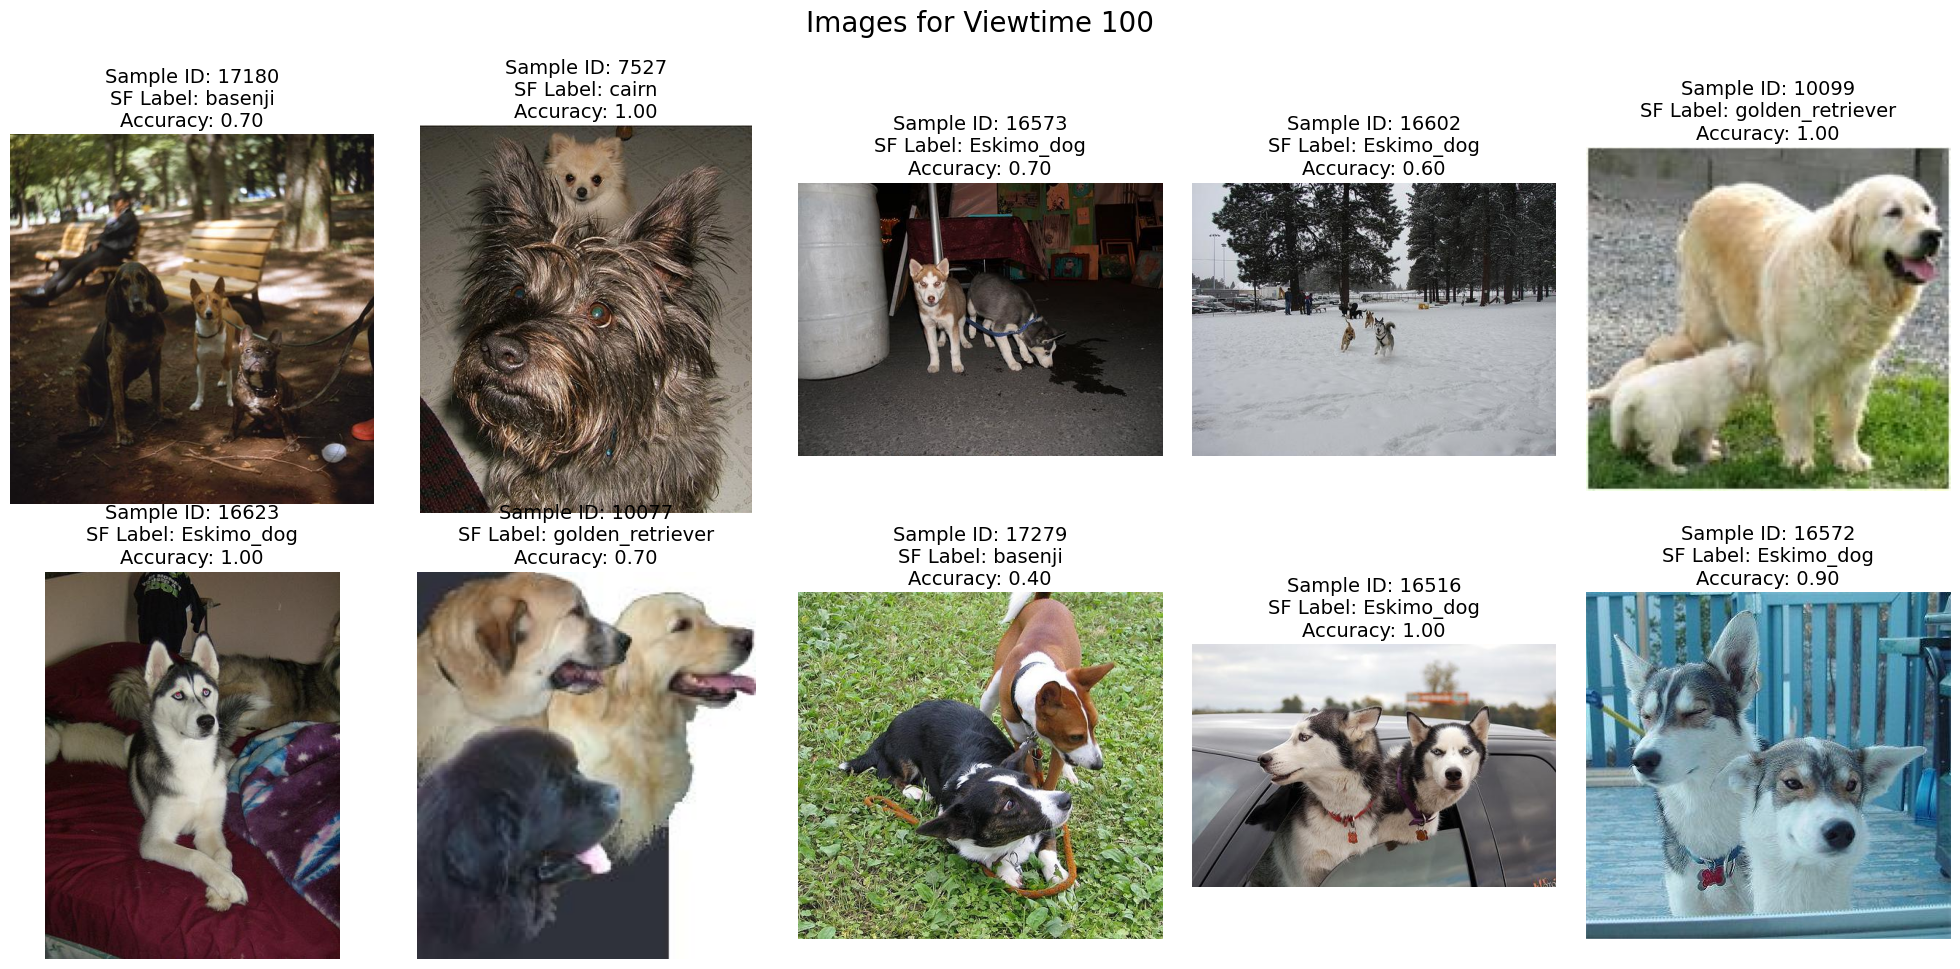

Average Accuracy: 0.8000


In [16]:
# Load Stanford Dogs dataset using ImageFolder
data_dir = "StanfordDogs_Dataset"
dataset = datasets.ImageFolder(data_dir)

# Create DataLoader for the dataset
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Function to display images for given sample_ids
def display_images(viewtime, sample_ids, dataset, sdogs_df):
    num_images = len(sample_ids)
    num_cols = min(num_images, 5)  # Display at most 5 images per row
    num_rows = (num_images + num_cols - 1) // num_cols
    
    plt.figure(figsize=(20, 10))  # Larger figure size
    
    plt.suptitle(f'Images for Viewtime {viewtime}', fontsize=20)  # Increase title fontsize
    
    # Filter the dataframe to include only the data for the specified viewtime
    viewtime_data = sdogs_df[sdogs_df['viewtime'] == viewtime]
    
    total_accuracy = 0
    
    for i, sample_id in enumerate(sample_ids):
        image_path = dataset.samples[sample_id][0]
        image = plt.imread(image_path)
        
        # Get label information
        label = viewtime_data.loc[viewtime_data['stanford_sampleid'] == sample_id, 'stanford_label'].values[0]
        
        # Compute accuracy for the current sample_id
        num_correct = viewtime_data.loc[(viewtime_data['stanford_sampleid'] == sample_id) & (viewtime_data['easy_correct'] == 1)].shape[0]
        num_annotators = viewtime_data.loc[viewtime_data['stanford_sampleid'] == sample_id].shape[0]
        accuracy = num_correct / num_annotators if num_annotators > 0 else 0
        
        total_accuracy += accuracy
        
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image)
        plt.title(f'Sample ID: {sample_id}\nSF Label: {label}\nAccuracy: {accuracy:.2f}', fontsize=14)  # Increase title fontsize
        plt.axis('off')
    
    # Calculate average accuracy
    average_accuracy = total_accuracy / num_images
    
    plt.tight_layout()
    plt.show()
    
    print(f'Average Accuracy: {average_accuracy:.4f}')  # Print average accuracy

# Example usage:
# View images with annotated property, and average accuracy within a cohort
sample_ids_to_display = diff_ft_ids['multi-dog'] # Replace key with chosen image prop
viewtime = 100  # Replace with chosen viewtime cohort
display_images(viewtime, sample_ids_to_display, dataset, sdogs_df)

# RQ4: How can consensus algorithms mitigate the impact of time limits on performance accuracy?

Processing viewtime 2500ms: 100%|███████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.01s/it]


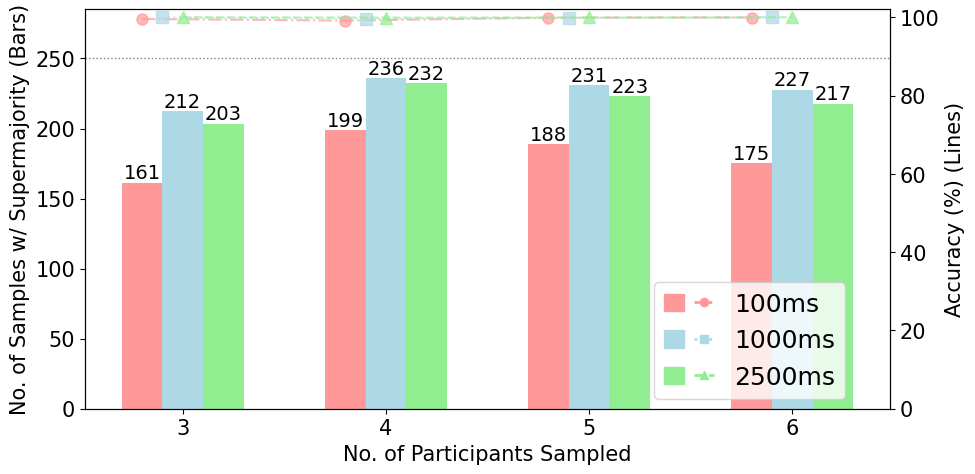

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm

np.random.seed(100)

viewtimes = [100, 1000, 2500]

def calculate_strong_majority_data(df, viewtimes, threshold=2/3):
    num_samples_majority = {viewtime: [] for viewtime in viewtimes}
    accuracies_majority = {viewtime: [] for viewtime in viewtimes}

    for viewtime in viewtimes:
        participants = df[df['viewtime'] == viewtime]['participant_id'].unique()
        for num_votes in tqdm(range(3, 7), desc=f'Processing viewtime {viewtime}ms'):
            majority_counts = 0
            correct_counts = 0
            for i in range(10):  # Number of iterations for sampling
                sampled_participants = np.random.choice(participants, num_votes, replace=False)
                sample_df = df[(df['viewtime'] == viewtime) & (df['participant_id'].isin(sampled_participants))]
                
                for test_qid, group in sample_df.groupby('test_qid'):
                    label_counts = group['answer'].value_counts()
                    if len(label_counts) > 0 and label_counts.max() > threshold * num_votes:
                        majority_counts += 1
                        majority_label = label_counts.idxmax()
                        majority_rows = group[group['answer'] == majority_label]
                        correct_counts += majority_rows['easy_correct'].iloc[0]
            
            num_samples_majority[viewtime].append(majority_counts / 10)
            accuracies_majority[viewtime].append((correct_counts / majority_counts) * 100 if majority_counts > 0 else 0)
    
    return num_samples_majority, accuracies_majority

num_samples_majority, accuracies_majority = calculate_strong_majority_data(sdogs_df, viewtimes)

# Plotting
x_ticks = list(range(3, 7))
colors = ['#FF9999', '#ADD8E6', '#90EE90']
markers = ['o', 's', '^']
linestyles = ['-.', 'dotted', '--']

plt.rcParams.update({'font.size': 15})

fig, ax1 = plt.subplots(figsize=(10, 5))

width = 0.2
for i, viewtime in enumerate(viewtimes):
    bars = ax1.bar([x + width*i for x in x_ticks], num_samples_majority[viewtime], width=width, color=colors[i], label=f'{viewtime}ms', zorder=2)
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=14, color='black', zorder=4)

ax2 = ax1.twinx()

for i, viewtime in enumerate(viewtimes):
    ax2.plot([x + (width*i/2) for x in x_ticks], accuracies_majority[viewtime], color=colors[i], marker=markers[i], linestyle=linestyles[i], label=f'{viewtime}ms Accuracy', zorder=3, markersize=8, alpha=0.7)

ax1.set_ylim(0, 285)
ax2.set_ylim(0.0, 102.0)

ax1.set_xlabel('No. of Participants Sampled')
ax1.set_ylabel('No. of Samples w/ Supermajority (Bars)')
ax2.set_ylabel('Accuracy (%) (Lines)')
ax1.set_xticks([x + width for x in x_ticks])
ax1.set_xticklabels(x_ticks)

legend_handles = []
for i in range(len(viewtimes)):
    bar_patch = mpatches.Patch(color=colors[i])
    line_handle = plt.Line2D([0], [0], color=colors[i], marker=markers[i], linestyle=linestyles[i], lw=2)
    legend_handles.append((bar_patch, line_handle))

from matplotlib.legend_handler import HandlerTuple

fig.legend(handles=legend_handles, labels=[f'{viewtime}ms' for viewtime in viewtimes],
           handler_map={tuple: HandlerTuple(ndivide=None)}, loc='lower right', fontsize='large', ncol=1, bbox_to_anchor=(0.87, 0.15))

ax1.axhline(y=250, color='grey', linestyle='dotted', linewidth=1)

plt.tight_layout()
plt.savefig('majority-accuracy.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
accuracies_majority

{100: [99.56629491945476,
  99.14572864321607,
  99.89412387506617,
  99.94292237442922],
 1000: [99.95291902071564,
  99.66130397967824,
  99.82698961937716,
  99.95608256477821],
 2500: [100.0, 99.91386735572783, 99.95521719659651, 100.0]}

# RQ5: How does a view time limit affect the effort and satisfaction of crowd workers over the duration of our task?

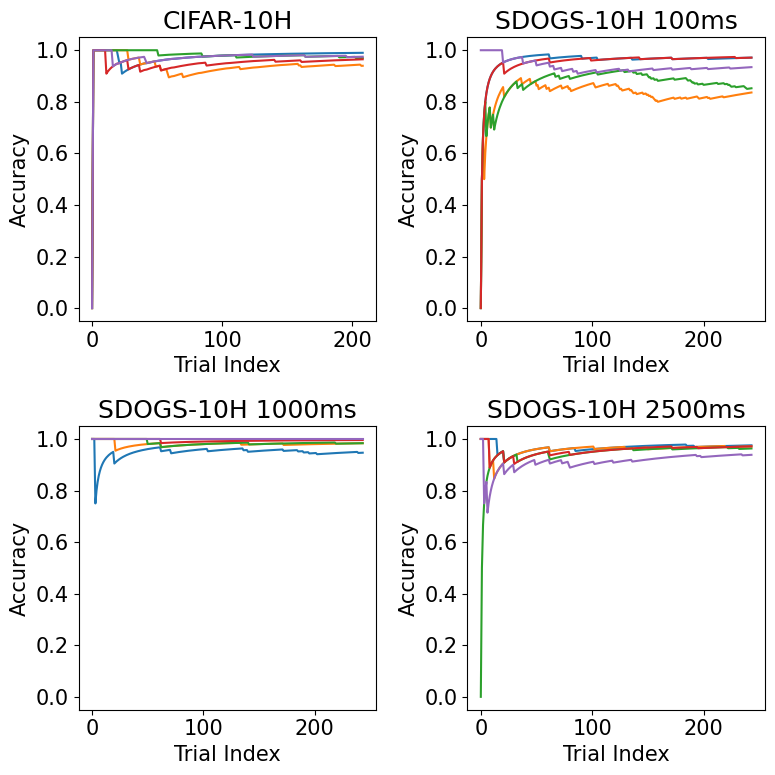

In [19]:
np.random.seed(100)

# Select a sample of 10 annotators
sample_annotators = nofilter_cifar_df['annotator_id'].sample(n=5).tolist()

# Calculate accuracy for each annotator
plt.figure(figsize=(8, 8))

# First subplot (Top Left)
plt.subplot(2, 2, 1)
for annotator_id in sample_annotators:
    annotator_data = nofilter_cifar_df[nofilter_cifar_df['annotator_id'] == annotator_id]
    correct_answers = annotator_data['correct_guess']
    trial_count = len(annotator_data)
    accuracy = [(correct_answers.iloc[:i].sum() / i) if i > 0 else 0 for i in range(trial_count)]
    plt.plot(annotator_data['trial_index'], accuracy, label=f'Annotator {annotator_id}')
plt.title('CIFAR-10H')
plt.xlabel('Trial Index')
plt.ylabel('Accuracy')
plt.ylim([-0.05, 1.05])

np.random.seed(100)

# Group data by 'viewtime'
viewtime_groups = sdogs_df.groupby('viewtime')

# Iterate over viewtime cohorts
subplot_idx = 2
for viewtime, viewtime_data in viewtime_groups:
    # Sample 5 participants
    sampled_participants = viewtime_data['participant_id'].sample(n=5)

    plt.subplot(2, 2, subplot_idx)
    subplot_idx += 1
    
    # Calculate cumulative accuracy for each annotator at every test_qid
    for participant_id in sampled_participants:
        participant_data = viewtime_data[viewtime_data['participant_id'] == participant_id]
        accuracy = []
        correct_answers = 0
        total_questions = 0
        for qid in participant_data['test_qid']:
            total_questions += 1
            correct_answer = participant_data[participant_data['test_qid'] == qid]['easy_correct'].values[0]
            if correct_answer:
                correct_answers += 1
            accuracy.append(correct_answers / total_questions)

        # Plot accuracy for the annotator
        plt.title(f'SDOGS-10H {viewtime}ms')
        plt.plot(range(len(accuracy)), accuracy)
    
    # Customize plot
    plt.xlabel('Trial Index')
    plt.ylabel('Accuracy')
    # Set vertical margin
    plt.ylim([-0.05, 1.05])

plt.tight_layout()
plt.savefig('accuracy-over-trial.pdf', dpi=300)
plt.show()

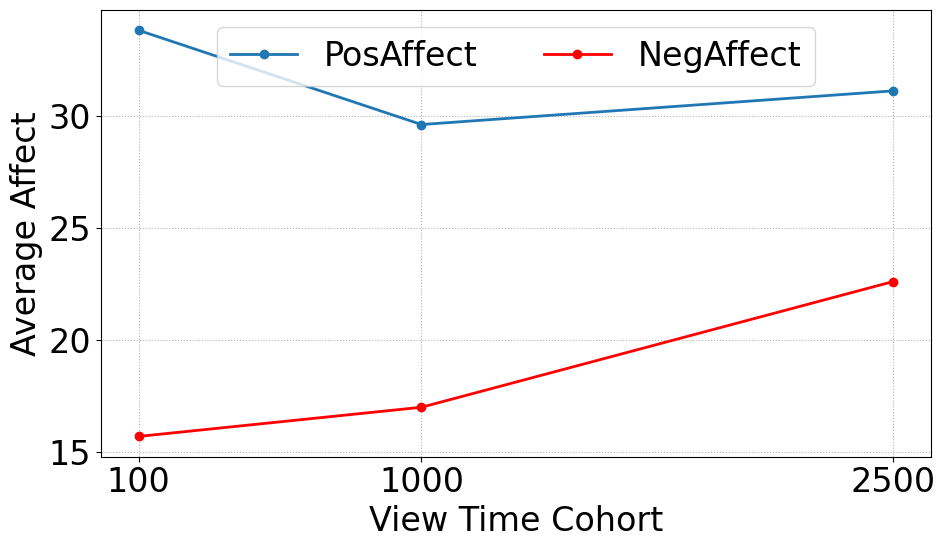

In [20]:
# Grouping data by viewtime and calculating mean of PosAffect and NegAffect
grouped_data = sdogs_df.groupby('viewtime').agg({'PosAffect': 'mean', 'NegAffect': 'mean'}).reset_index()

# Plotting
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(10, 6))
plt.plot(grouped_data['viewtime'], grouped_data['PosAffect'], label='PosAffect', marker='o', linewidth=2)
plt.plot(grouped_data['viewtime'], grouped_data['NegAffect'], label='NegAffect', marker='o', color='red', linewidth=2)
plt.xlabel('View Time Cohort')
plt.ylabel('Average Affect')
plt.xticks([100, 1000, 2500])  # Specify the x-axis ticks
plt.grid(linestyle='dotted')
plt.legend(ncol=2, loc=9) # 9 means top center
plt.tight_layout()
plt.savefig('affect-scores.pdf', dpi=300)
plt.show()

In [21]:
# Assuming sdogs_df is already defined
# Calculate the difference between PosAffect and NegAffect for each participant
sdogs_df['AffectDifference'] = sdogs_df['PosAffect'] - sdogs_df['NegAffect']

# Perform Kruskal-Wallis test
groups = sdogs_df.groupby('viewtime')['AffectDifference'].apply(list)
kruskal_result = kruskal(*groups)

print("Kruskal-Wallis test result:")
print(f"Statistic = {kruskal_result.statistic}, p-value = {kruskal_result.pvalue}")

# If the Kruskal-Wallis test is significant, perform Dunn's post hoc test
if kruskal_result.pvalue < 0.05:
    dunn_results = posthoc_dunn(sdogs_df, val_col='AffectDifference', group_col='viewtime')

    # Print Dunn post hoc test results
    print("\nDunn post hoc test results:")
    print(dunn_results)
else:
    print("Kruskal-Wallis test is not significant; no post hoc test needed.")

Kruskal-Wallis test result:
Statistic = 736.9622266845174, p-value = 9.347291570960534e-161

Dunn post hoc test results:
               100           1000           2500
100    1.000000e+00  5.383752e-24  4.578007e-159
1000   5.383752e-24  1.000000e+00   4.032014e-63
2500  4.578007e-159  4.032014e-63   1.000000e+00
